# This notebook does deep dive to figure out which test in the SBRL dataset results in the boost of the FoF prediction in the reporter assay?

In [ ]:
import sys
sys.path.append("../..")
import pandas as pd
import numpy as np
from src.models.baseline_ML_functions import get_test_data, common_name_to_genus_speices
from src.eda.eda_cdc import *
import seaborn as sns
from sys import platform 
prefix = '../../data_files/'
prefixG = '/Volumes/GoogleDrive'
from sklearn.metrics import balanced_accuracy_score
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.decomposition import PCA
pca = PCA(n_components = 1)
from src.models.NN_functions import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
reporter_test_df = pd.read_csv(prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/reporter/reporter_match_CDC_strains_total_test.csv') # Load reporter alone ML results
reporter_SBRL_test_df = pd.read_csv(prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/reporter/reporter_w_CDC_total_test1.csv') # Load SBRL + reporter ML results

In [3]:
reporter_mean = reporter_test_df.groupby('Common Name')[['Foe_prob_predictions', 'Foe']].mean().reset_index()
reporter_mean['pred_type'] = '- as -'
reporter_mean.loc[(reporter_mean['Foe'] == 0) & (reporter_mean['Foe_prob_predictions'] > 0.5), 'pred_type'] = '- as +'
reporter_mean.loc[(reporter_mean['Foe'] == 1) & (reporter_mean['Foe_prob_predictions'] < 0.5), 'pred_type'] = '+ as -'
reporter_mean.loc[(reporter_mean['Foe'] == 1) & (reporter_mean['Foe_prob_predictions'] > 0.5), 'pred_type'] = '+ as +'

In [4]:
reporter_sbrl_mean = reporter_SBRL_test_df.groupby('Common Name')[['Foe_prob_predictions', 'Foe']].mean().reset_index()
reporter_sbrl_mean['pred_type'] = '- as -'
reporter_sbrl_mean.loc[(reporter_sbrl_mean['Foe'] == 0) & (reporter_sbrl_mean['Foe_prob_predictions'] > 0.5), 'pred_type'] = '- as +'
reporter_sbrl_mean.loc[(reporter_sbrl_mean['Foe'] == 1) & (reporter_sbrl_mean['Foe_prob_predictions'] < 0.5), 'pred_type'] = '+ as -'
reporter_sbrl_mean.loc[(reporter_sbrl_mean['Foe'] == 1) & (reporter_sbrl_mean['Foe_prob_predictions'] > 0.5), 'pred_type'] = '+ as +'

In [5]:
# give each data point a prediction type label based on if it's a correct friend or foe prediction
reporter_SBRL_test_df['pred_type'] = '- as -'
reporter_SBRL_test_df.loc[(reporter_SBRL_test_df['Foe'] == 0) & (reporter_SBRL_test_df['Foe_prob_predictions'] > 0.5), 'pred_type'] = '- as +'
reporter_SBRL_test_df.loc[(reporter_SBRL_test_df['Foe'] == 1) & (reporter_SBRL_test_df['Foe_prob_predictions'] < 0.5), 'pred_type'] = '+ as -'
reporter_SBRL_test_df.loc[(reporter_SBRL_test_df['Foe'] == 1) & (reporter_SBRL_test_df['Foe_prob_predictions'] > 0.5), 'pred_type'] = '+ as +'

In [6]:
original_test_names = list(map(lambda x:x.split('_')[0], reporter_SBRL_test_df.columns[-29:-3]))
original_test_names.remove('instance')

# Plot features split by prediction type 
## If it's a binary test, only plot one of the two tests since one would be mirror image of the other
## If it's a categorical test, plot all of the test results. 

In [7]:
feature_dicts = {'MaC/SS = SS':'SS','MacC/SS = MacC':'MacC'}

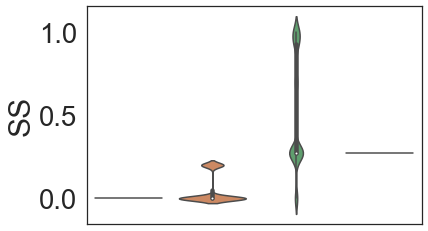

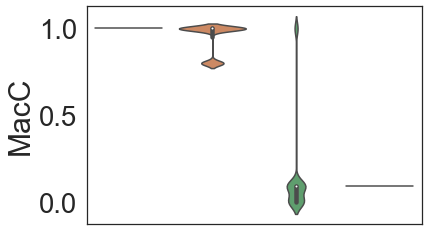

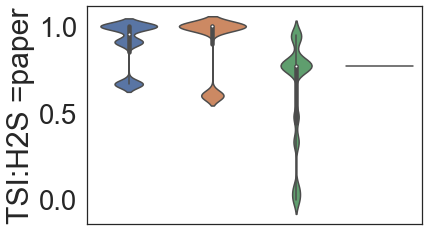

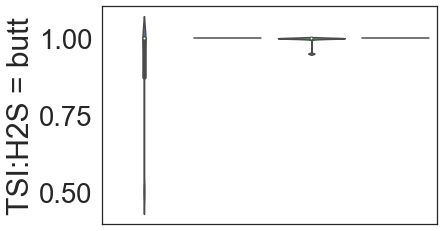

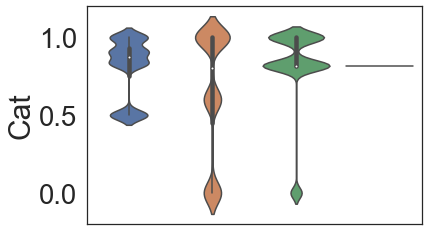

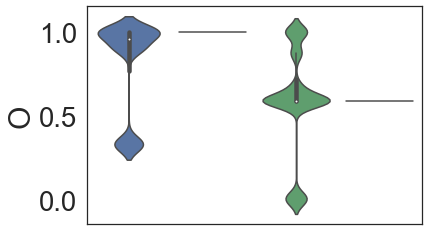

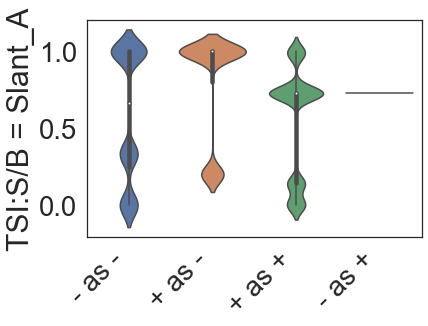

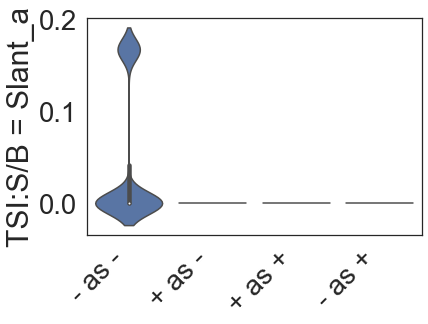

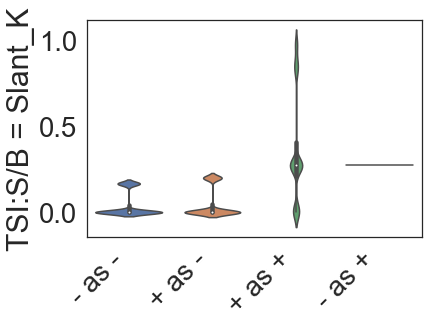

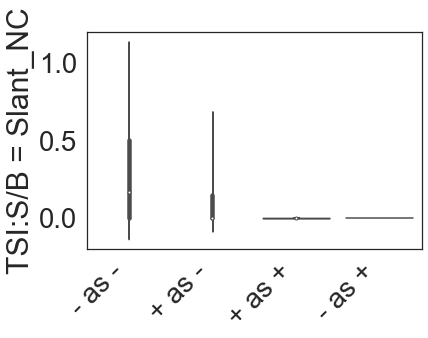

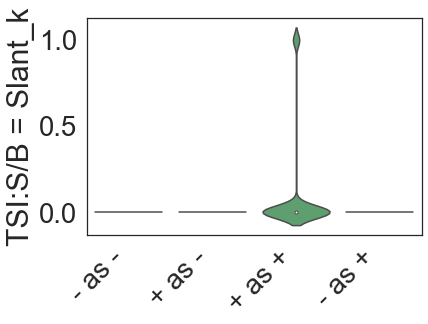

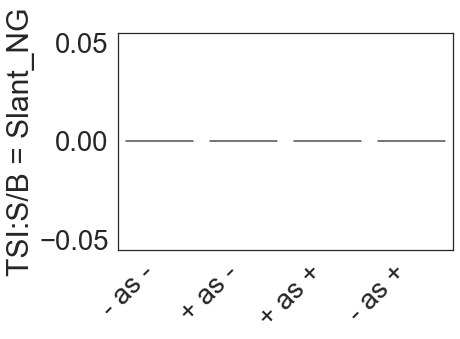

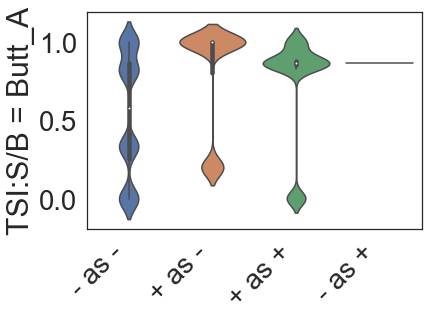

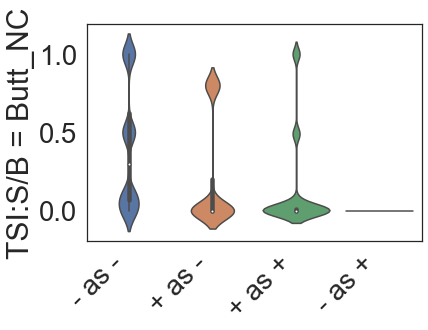

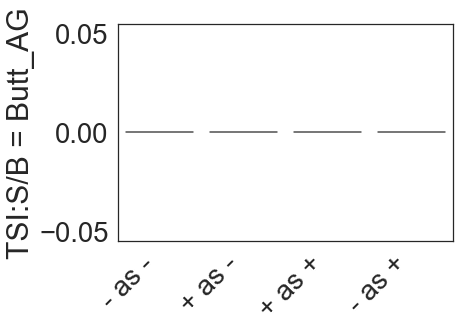

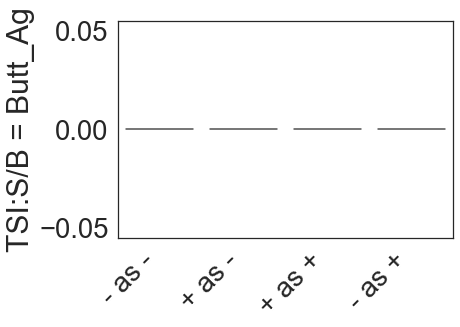

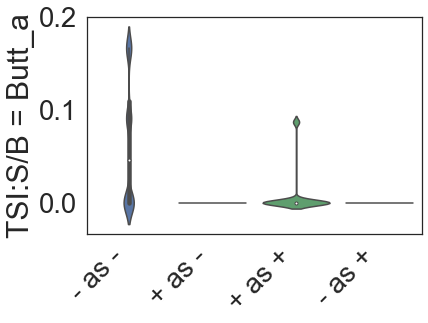

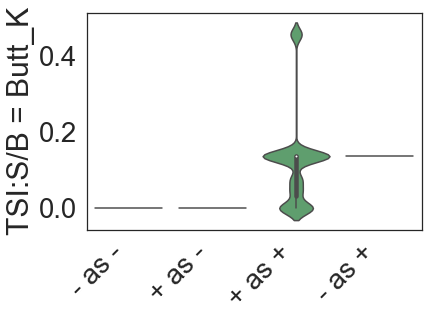

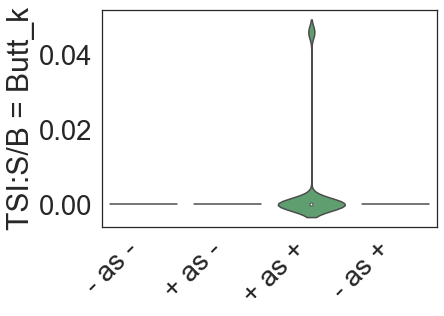

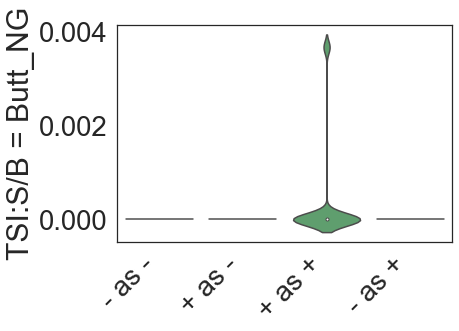

In [10]:
sns.set(font_scale = 2.5)
sns.set_style('white')
test_counts = Counter(original_test_names)
test_cols = reporter_SBRL_test_df.columns[-29:-3]
for test in test_counts:
    if test_counts[test] <= 2:
        col_to_plot = test_cols[test_cols.str.contains(test) == True][0]
        sns.violinplot(y = col_to_plot, x = 'pred_type', data = reporter_SBRL_test_df)
        plt.xticks([],rotation = 45, ha = 'right')
        ylabel = col_to_plot.split('_')[0]
        if ylabel in feature_dicts:
            ylabel = feature_dicts[ylabel]
        plt.ylabel(ylabel)
        plt.xlabel('')
        plt.show()
        plt.close()
    else:
        cols_to_plot = test_cols[test_cols.str.contains(test) == True]
        for col in cols_to_plot:
            sns.violinplot(y = col, x = 'pred_type', data = reporter_SBRL_test_df)
            plt.xticks(rotation = 45, ha = 'right')
            plt.xlabel('')
            plt.show()
            plt.close()

# For tests with categorical values, aggregate the results 

In [8]:
categorical_cols = ['TSI:S/B = Slant', 'TSI:S/B = Butt']

In [11]:
pca_dfs = []
for col in categorical_cols:
    test_cols_to_use = []
    for test in test_cols:
        if col in test:
            test_cols_to_use.append(test)
    pca_categorical = pca.fit_transform(reporter_SBRL_test_df[test_cols_to_use])    
    pca_df = pd.DataFrame(data = pca_categorical, columns = [f'pca_{col}'])
    pca_df['pred_type'] = '- as -'
    pca_df.loc[(reporter_SBRL_test_df['Foe'] == 0) & (reporter_SBRL_test_df['Foe_prob_predictions'] > 0.5), 'pred_type'] = '- as +'
    pca_df.loc[(reporter_SBRL_test_df['Foe'] == 1) & (reporter_SBRL_test_df['Foe_prob_predictions'] < 0.5), 'pred_type'] = '+ as -'
    pca_df.loc[(reporter_SBRL_test_df['Foe'] == 1) & (reporter_SBRL_test_df['Foe_prob_predictions'] > 0.5), 'pred_type'] = '+ as +'
    pca_dfs.append(pca_df)

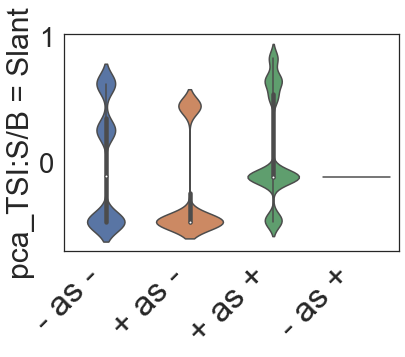

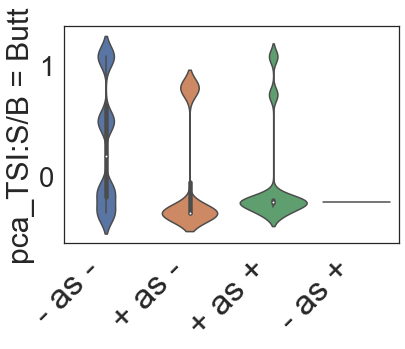

In [12]:
for col, pca_df in zip(categorical_cols, pca_dfs):
    sns.violinplot(y = f'pca_{col}', x = 'pred_type', data = pca_df)
    plt.xticks(rotation = 45, ha = 'right')
    plt.xlabel('')
    plt.tick_params(axis="x", labelsize=34)
    plt.show()
    plt.close()

# Quantify which test is important for the model

## Load entropy loss model

In [37]:
cdc_features = pd.read_csv(prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/processed_cdc_data.csv', index_col = 0)
all_IVV_df = pd.read_csv(prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/reporter/NN_all_IVV.csv')
all_IVV_df = all_IVV_df.groupby(['Common Name']).sample(400).reset_index(drop = True)
name_mapping = common_name_to_genus_speices()
all_IVV_df['genus_species'] = all_IVV_df['Common Name'].map(name_mapping)
cdc_features['instance_sum'] = scaler.fit_transform(
        cdc_features['instance_sum'].values.reshape(len(cdc_features),1))
all_IVV_w_cdc = pd.merge(all_IVV_df, cdc_features, left_on = 'genus_species', right_index = True)

In [40]:
original_test_names = list(map(lambda x:x.split('_')[0], cdc_features.columns))

In [41]:
test_counts = Counter(original_test_names)
test_cols = cdc_features.columns
cols_to_use = []
cols_to_reduce = []
for test in test_counts:
    if test_counts[test] <= 2:
        col = test_cols[test_cols.str.contains(test) == True][0]
        cols_to_use.append(col)
    else:
        cols = test_cols[test_cols.str.contains(test) == True].tolist()
        cols_to_reduce.append(cols)

In [43]:
for cols in cols_to_reduce:
    pca_categorical = pca.fit_transform(all_IVV_w_cdc[cols])    
    original_col_name = cols[0].split('_')[0]
    all_IVV_w_cdc[f'pca_{original_col_name}'] = pca_categorical
    cols_to_use.append(f'pca_{original_col_name}')

In [44]:
# take two IVV strains as the controls (since ivv_w_cdc_joinedthey match to the CDC instances so could add the CDC features to the model)
new_controls1 = all_IVV_w_cdc[all_IVV_w_cdc['Common Name'].isin(['NIST0012','NIST0027'])]
new_test1 = all_IVV_w_cdc[~all_IVV_w_cdc['Common Name'].isin(['NIST0012','NIST0027'])]

## Use drop column test to determine feature importance by running ML with a single column dropped at a time

In [45]:
cols_to_drop = cols_to_use.copy()
cols_to_drop.remove('instance_sum')

In [46]:
feature_cols1 = [col for col in new_controls1 if 'scaled' in col] + cols_to_use

In [47]:
binarizer = lambda x:0 if x < 0.5 else 1
vfunc = np.vectorize(binarizer)

In [48]:
cols_to_drop.insert(0, None) # test drop no column first as the control

In [50]:
# For loop to drop each column 
acc_list = []
col_list = []
for col in cols_to_drop:
    for i in range(5):
        feature_cols_to_test = feature_cols1.copy()
        if col != None:
            feature_cols_to_test.remove(col)
        result = run_custom_model(adjusted_bce_n_entropy_loss(shift = 0.15, weight = 1.5), new_controls1, new_test1, feature_cols_to_test, ['Foe', 'org_index'], epochs = 50, batch_size = 32)
        binary_result = vfunc(result)
        acc_list.append(round(balanced_accuracy_score(new_test1['Foe'], binary_result), 2))
        if col == None:
            col_list.append('None')
        else:
            col_list.append(col)

In [51]:
acc = pd.DataFrame({'col dropped':col_list, 'acc':acc_list})

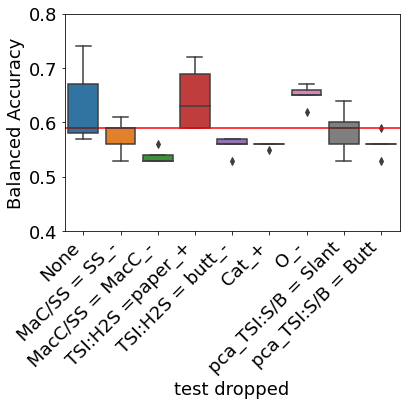

In [119]:
plt.rcParams.update({'font.size':18})
sns.boxplot(x = 'col dropped', y = 'acc', data = acc)
plt.ylim(0.4,0.8)
plt.xlabel('test dropped')
plt.ylabel('Balanced Accuracy')
plt.xticks(rotation= 45, ha = 'right')
plt.axhline(y = acc[acc['col dropped'] == 'None']['acc'].median(), color = 'r');

In [ ]:
## A different way to present the feature importance is 1 - test accuracy/original accuracy

In [53]:
control_acc = acc[acc['col dropped'] == 'None']['acc'].mean()
acc['importance'] = 1-(acc['acc']/ control_acc)

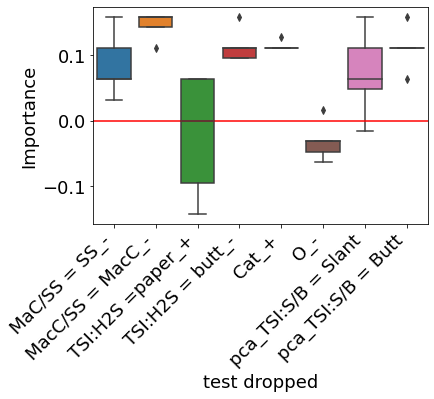

In [116]:
sns.boxplot(x = 'col dropped', y = 'importance', data = acc[acc['col dropped'] != 'None'])
plt.axhline(y = 0, color = 'r')
plt.xticks(rotation= 45, ha = 'right')
plt.xlabel('test dropped')
plt.ylabel('Importance');